# Analyze Facebook Data Using IBM Watson and IBM Data Platform

This is a notebook written in `Python_3.5` meant to show how anyone can enrich and analyze a combined dataset of unstructured and strucutured information with IBM Watson and IBM Data Platform. For this example we are using a standard Facebook Analytics export which features texts from posts, articles and thumbnails, along with standard performance metrics such as likes, shares, and impressions. 

1.  First, we use the Watson Tone Analyzer Service to enrich the Facebook Posts by pulling out `Emotion Tones` and related `Keywords`. 

2.  We will prep the data for analysis and visualization The end result will be a Pandas DataFrames that will contain the results of the analysis

3.  Finally, we will include services from IBM's Data Platform, including IBM's own data visualization library PixieDust, to analyze the data and visualize our results.

<a id="part1"></a>
#  Part I - Enrich
<a id='setup'></a> 
## 1. Setup
<a id="setup1"></a> Packages

In [1]:
!pip install --upgrade watson-developer-cloud
!pip install --upgrade beautifulsoup4

Requirement already up-to-date: watson-developer-cloud in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sce6-e6b1c3357c3b2f-e6c62d2acbd3/.local/lib/python3.5/site-packages
Requirement already up-to-date: python-dateutil>=2.5.3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sce6-e6b1c3357c3b2f-e6c62d2acbd3/.local/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement already up-to-date: pysolr<4.0,>=3.3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sce6-e6b1c3357c3b2f-e6c62d2acbd3/.local/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement already up-to-date: requests<3.0,>=2.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sce6-e6b1c3357c3b2f-e6c62d2acbd3/.local/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement already up-to-date: pyOpenSSL>=16.2.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sce6-e6b1c3357c3b2f-e6c62d2acbd3/.local/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement already up-to-date: six

<a id="pixie"></a>
### 1.2 Install PixieDust Library
This notebook provides an overview of how to use the PixieDust Library to analyze and visualize various data sets. If you are new to PixieDust or would like to learn more about the library, please go to this [Introductory Notebook](https://apsportal.ibm.com/exchange/public/entry/view/5b000ed5abda694232eb5be84c3dd7c1) or visit the [PixieDust Github](https://ibm-cds-labs.github.io/pixiedust/). The `Setup` section for this notebook uses instructions from the [Intro To PixieDust](https://github.com/ibm-cds-labs/pixiedust/blob/master/notebook/Intro%20to%20PixieDust.ipynb) notebook

To ensure you are running the latest version of PixieDust uncomment and run the following cell. Do not run this cell if you installed PixieDust locally from source and want to continue to run PixieDust from source.

In [2]:
!pip install --user --upgrade pixiedust

Requirement already up-to-date: pixiedust in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sce6-e6b1c3357c3b2f-e6c62d2acbd3/.local/lib/python3.5/site-packages
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sce6-e6b1c3357c3b2f-e6c62d2acbd3/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: geojson in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sce6-e6b1c3357c3b2f-e6c62d2acbd3/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sce6-e6b1c3357c3b2f-e6c62d2acbd3/.local/lib/python3.5/site-packages (from pixiedust)


<a id="setup2"></a>
### 1.3 Import Packages and Libraries
To check if you have package already installed, open new cell and write: *help.('Package Name')*

In [3]:
import json
import sys
import watson_developer_cloud
from watson_developer_cloud import ToneAnalyzerV3, VisualRecognitionV3
import watson_developer_cloud.natural_language_understanding.features.v1 as features

import operator
from functools import reduce
from io import StringIO
import numpy as np
from bs4 import BeautifulSoup as bs
from operator import itemgetter
from os.path import join, dirname
import pandas as pd
import numpy as np
import requests
import pixiedust

Pixiedust database opened successfully


<a id='setup3'></a>
### 1.4 Service Credentials From Bluemix for Watson Services

In [19]:
tone_analyzer = ToneAnalyzerV3(
 version='2016-05-19',
 username='6051d902-6157-46fb-861b-48f259a38cfa',
 password='MQzuTNl31qOP'
)


#nlu=watson_developer_cloud.NaturalLanguageUnderstandingV1(
#   version='2017-02-27',
 #  username= 'e0555722-18f6-46d7-ab20-cbbbe49ffe97',
 #  password= 'UsGjWYaWysT0'
#)

<a id='load'></a> 
## 2. Load Data

### 2.1 Load data from Object Storage
IBM® Object Storage for Bluemix® provides provides you with access to a fully provisioned Swift Object Storage account to manage your data. Object Storage uses OpenStack Identity (Keystone) for authentication and can be accessed directly by using [OpenStack Object Storage (Swift) API v3](http://developer.openstack.org/api-ref-identity-v3.html#credentials-v3). 



In [5]:
# The code was removed by DSX for sharing.

,Post ID,Permalink,Post Message,Countries,Languages,Posted,Audience Targeting,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,...,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative feedback - unlike_page_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Lifetime Negative Feedback from Users by Type - unlike_page_clicks
0,187446750783_10153359024455784,https://www.facebook.com/ibmwatson/posts/10153...,Hate FCUSA. Treadmills are always broken!,NaN,NaN,12/31/15 6:28,,2291,2291,0,...,4.0,21.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,187446750783_10153215851080784,https://www.facebook.com/ibmwatson/posts/10153...,Run down equipment at this place. Not happy.,NaN,NaN,12/31/15 6:26,,158,158,0,...,307.0,NaN,NaN,544.0,NaN,NaN,NaN,NaN,NaN,NaN
2,187446750783_10153357233820784,https://www.facebook.com/ibmwatson/posts/10153...,Difficult to sign up for classes,NaN,NaN,12/30/15 7:00,,4203,4203,0,...,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN
3,187446750783_10153355476175784,https://www.facebook.com/ibmwatson/posts/10153...,Does anyone know how to sign up for FCUSA clas...,NaN,NaN,12/29/15 6:26,,3996,3996,0,...,NaN,44.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,187446750783_10153353697105784,https://www.facebook.com/ibmwatson/posts/10153...,Went to work out yesterday. 6 or 8 treadmills ...,NaN,NaN,12/28/15 7:05,,2847,2847,0,...,62.0,19.0,37.0,83.0,1.0,NaN,NaN,1.0,NaN,NaN


In [6]:
#Make sure this equals the variable above.
df = df_data_1
df.head()

,Post ID,Permalink,Post Message,Countries,Languages,Posted,Audience Targeting,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,...,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative feedback - unlike_page_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Lifetime Negative Feedback from Users by Type - unlike_page_clicks
0,187446750783_10153359024455784,https://www.facebook.com/ibmwatson/posts/10153...,Hate FCUSA. Treadmills are always broken!,NaN,NaN,12/31/15 6:28,,2291,2291,0,...,4.0,21.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,187446750783_10153215851080784,https://www.facebook.com/ibmwatson/posts/10153...,Run down equipment at this place. Not happy.,NaN,NaN,12/31/15 6:26,,158,158,0,...,307.0,NaN,NaN,544.0,NaN,NaN,NaN,NaN,NaN,NaN
2,187446750783_10153357233820784,https://www.facebook.com/ibmwatson/posts/10153...,Difficult to sign up for classes,NaN,NaN,12/30/15 7:00,,4203,4203,0,...,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN
3,187446750783_10153355476175784,https://www.facebook.com/ibmwatson/posts/10153...,Does anyone know how to sign up for FCUSA clas...,NaN,NaN,12/29/15 6:26,,3996,3996,0,...,NaN,44.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,187446750783_10153353697105784,https://www.facebook.com/ibmwatson/posts/10153...,Went to work out yesterday. 6 or 8 treadmills ...,NaN,NaN,12/28/15 7:05,,2847,2847,0,...,62.0,19.0,37.0,83.0,1.0,NaN,NaN,1.0,NaN,NaN


In [7]:
# The code was removed by DSX for sharing.

<a id='prepare'></a>
## 3. Prepare Data



<a id='prepare1'></a>
###  3.1 Data Cleansing with Python
Renaming columns, removing noticable noise in the data, pulling out URLs and appending to a new column to run through NLU

In [8]:
df.rename(columns={'Post Message': 'Text'}, inplace=True)

In [9]:
df = df.drop([0])
df.head()

,Post ID,Permalink,Text,Countries,Languages,Posted,Audience Targeting,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,...,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative feedback - unlike_page_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Lifetime Negative Feedback from Users by Type - unlike_page_clicks
1,187446750783_10153215851080784,https://www.facebook.com/ibmwatson/posts/10153...,Run down equipment at this place. Not happy.,NaN,NaN,12/31/15 6:26,,158,158,0,...,307.0,NaN,NaN,544.0,NaN,NaN,NaN,NaN,NaN,NaN
2,187446750783_10153357233820784,https://www.facebook.com/ibmwatson/posts/10153...,Difficult to sign up for classes,NaN,NaN,12/30/15 7:00,,4203,4203,0,...,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN
3,187446750783_10153355476175784,https://www.facebook.com/ibmwatson/posts/10153...,Does anyone know how to sign up for FCUSA clas...,NaN,NaN,12/29/15 6:26,,3996,3996,0,...,NaN,44.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,187446750783_10153353697105784,https://www.facebook.com/ibmwatson/posts/10153...,Went to work out yesterday. 6 or 8 treadmills ...,NaN,NaN,12/28/15 7:05,,2847,2847,0,...,62.0,19.0,37.0,83.0,1.0,NaN,NaN,1.0,NaN,NaN
5,187446750783_10153351555645784,https://www.facebook.com/ibmwatson/posts/10153...,Can never figure out how to sign up for a class,NaN,NaN,12/27/15 7:00,,2514,2514,0,...,71.0,6.0,13.0,97.0,NaN,NaN,NaN,NaN,NaN,NaN


<a id='enrich'></a> 
## 4. Enrichment Time!
<a id='nlupost'></a>
###  4.1 NLU for the Post Text
Below uses Natural Language Understanding to iterate through each post and extract the enrichment features we want to use in our future analysis.

Each feature we extract will be appended to the `.csv` in a new column we determine at the end of this script. If you want to run this same script for the other columns, define `free_form_responses` to the column name, if you are using URLs, change `text=response` parameter to `url=response`, and update the new column names as you see fit. 

After we extract all of the Keywords and Entities from each Post, we have a column with multiple Keywords, and Entities separated by commas. For our Analysis in Part II we wanted also wanted the top Keyword and Entity for each Post. Because of this, we added two new columns to capture the `MaxTextKeyword` and `MaxTextEntity`

 <a id='tonepost'></a> 
### 4.4 Tone Analyzer for Post Text

In [18]:
# Extract the free form text response from the data frame
# If you are using this script for a diff CSV, you will have to change this column name
free_form_responses = df['Text']
import json
#Create a list to store the enriched data

highestEmotionTone = []
emotionToneScore = []

languageToneScore = []
highestLanguageTone = []

socialToneScore = []
highestSocialTone = []


for idx, response in enumerate(free_form_responses):
    #print(response)
    #print("Processing record number: ", idx, " and text: ", response)
    try:

        enriched_json = json.loads(json.dumps(tone_analyzer.tone(response,content_type='text/plain')))

        
        if 'tone_categories' in enriched_json['document_tone']:
            me = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['tone_name']      
            highestEmotionTone.append(me)
            you = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['score']
            emotionToneScore.append(you)
            
            me1 = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['tone_name']      
            highestLanguageTone.append(me1)
            you1 = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['score']
            languageToneScore.append(you1)
            
            me2 = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['tone_name']      
            highestSocialTone.append(me2)
            you2 = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['score']
            socialToneScore.append(you2)
            
            
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        emotionToneScore.append(' ')
        highestEmotionTone.append(' ')
        languageToneScore.append(' ')
        highestLanguageTone.append(' ')
        socialToneScore.append(' ')
        highestSocialTone.append(' ')
        pass
    
if highestEmotionTone:
    df['highestEmotionTone'] = highestEmotionTone    
if emotionToneScore:
    df['emotionToneScore'] = emotionToneScore
    
if languageToneScore:
    df['languageToneScore'] = languageToneScore
if highestLanguageTone:
    df['highestLanguageTone'] = highestLanguageTone
    
if highestSocialTone:
    df['highestSocialTone'] = highestSocialTone    
if socialToneScore:
    df['socialToneScore'] = socialToneScore 
    
df.head(20)
#df.info()

,Post ID,Permalink,Text,Countries,Languages,Posted,Audience Targeting,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,...,Lifetime Negative feedback - unlike_page_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Lifetime Negative Feedback from Users by Type - unlike_page_clicks,highestEmotionTone,emotionToneScore,languageToneScore,highestLanguageTone,highestSocialTone,socialToneScore
1,187446750783_10153215851080784,https://www.facebook.com/ibmwatson/posts/10153...,Run down equipment at this place. Not happy.,NaN,NaN,12/31/15 6:26,,158,158,0,...,NaN,NaN,NaN,NaN,Sadness,0.248208,0.000000,Analytical,Extraversion,0.695989
2,187446750783_10153357233820784,https://www.facebook.com/ibmwatson/posts/10153...,Difficult to sign up for classes,NaN,NaN,12/30/15 7:00,,4203,4203,0,...,NaN,NaN,NaN,NaN,Sadness,0.754500,0.000000,Analytical,Agreeableness,0.457798
3,187446750783_10153355476175784,https://www.facebook.com/ibmwatson/posts/10153...,Does anyone know how to sign up for FCUSA clas...,NaN,NaN,12/29/15 6:26,,3996,3996,0,...,NaN,NaN,NaN,NaN,Sadness,0.451078,0.822231,Tentative,Emotional Range,0.522052
4,187446750783_10153353697105784,https://www.facebook.com/ibmwatson/posts/10153...,Went to work out yesterday. 6 or 8 treadmills ...,NaN,NaN,12/28/15 7:05,,2847,2847,0,...,NaN,1.0,NaN,NaN,Sadness,0.704908,0.992521,Analytical,Agreeableness,0.446476
5,187446750783_10153351555645784,https://www.facebook.com/ibmwatson/posts/10153...,Can never figure out how to sign up for a class,NaN,NaN,12/27/15 7:00,,2514,2514,0,...,NaN,NaN,NaN,NaN,Sadness,0.533868,0.653099,Analytical,Emotional Range,0.694515
6,187446750783_10153348958265784,https://www.facebook.com/ibmwatson/posts/10153...,"Heard their classes are good, but can't figure...",NaN,NaN,12/26/15 10:20,,5873,5873,0,...,NaN,NaN,1.0,NaN,Joy,0.668382,0.589295,Analytical,Conscientiousness,0.461318
7,187446750783_10153345000615784,https://www.facebook.com/ibmwatson/posts/10153...,We may be looking for another gym! Too many e...,NaN,NaN,12/24/15 7:52,,2738,2738,0,...,NaN,NaN,NaN,NaN,Sadness,0.466301,0.972662,Tentative,Agreeableness,0.665242
8,187446750783_10153343169940784,https://www.facebook.com/ibmwatson/posts/10153...,Can't believe they can't keep a treadmill work...,NaN,NaN,12/23/15 7:55,,6761,6761,0,...,NaN,2.0,1.0,NaN,Joy,0.202902,0.889390,Tentative,Agreeableness,0.293064
9,187446750783_10153341048340784,https://www.facebook.com/ibmwatson/posts/10153...,I loathe going to FCUSA. Equipment never work...,NaN,NaN,12/22/15 8:34,,38054,38054,0,...,NaN,3.0,6.0,NaN,Sadness,0.569851,0.979426,Confident,Conscientiousness,0.471664
10,187446750783_10153338984525784,https://www.facebook.com/ibmwatson/posts/10153...,"My membership is a rip-off. First, the treadm...",NaN,NaN,12/21/15 7:12,,7422,7422,0,...,NaN,NaN,2.0,NaN,Sadness,0.891278,0.971165,Confident,Conscientiousness,0.802180


 <a id='write'></a>
## Enrichment is now COMPLETE!
<a id='write1'></a> 
Last step is to write and save the enriched dataframe to SoftLayer's Object Storage.

Since we already created the `localfilename` variable in the Setup stage and defined the necessary credentials, this snippet will work for all new files and does not need to be changed.

<a id='write2'></a> Make sure to change the "credential" argument below matches the variable name of the credentials you imported in the Setup Phase.

<a id="part2"></a> 
# Part II - Analysis
<a id='prepare'></a>
## 1. Tone Analysis
 <a id='visualizations'></a>

#### Post Tone Dataframe

In [20]:
#Create a new dataframe for analyzing the emotional tone from each Facebook entry
# 
post_tones = ["highestEmotionTone"]

#Create a new dataframe with tones
df_post_tones = df[post_tones]
#Aggregate the tone data for Analysis
tones = df_post_tones
tones = pd.DataFrame(tones.groupby('highestEmotionTone').size().reset_index(name='Posts'))
tones.head()

,highestEmotionTone,Posts
0,Anger,12
1,Joy,22
2,Sadness,26


# PixieDust lets you visualize your data in just a few clicks using the display() API. You can find more info at https://ibm-cds-labs.github.io/pixiedust/displayapi.html. The following cell creates a DataFrame and uses the display() API to create a pie chart:


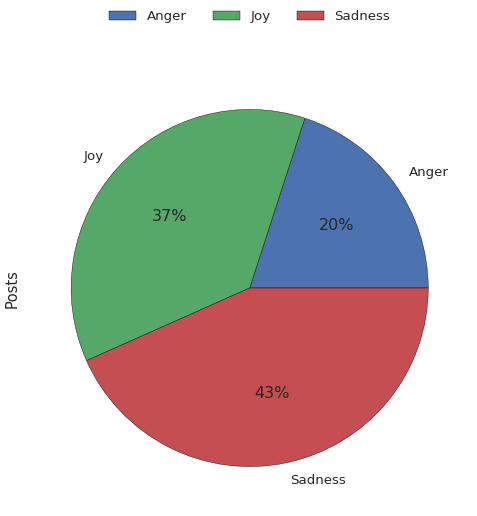

In [22]:
#Use the Pixiedust library to easily visualize the data
display(tones)

## 2. Language Analysis for Negative Tones

In [51]:
import pandas as pd
#Filter by Negative Tones

df_negative=df.loc[df['highestEmotionTone'] != 'Joy']


df_words = pd.DataFrame(df_negative['Text'])


df_words=df_words['Text'].str.split(' ', expand=True).stack().to_frame()
df_words.columns=['Word']
df_words=pd.DataFrame(df_words.groupby('Word').size().reset_index(name='Count'))
df_words=df_words.loc[~df_words['Word'].isin(['never','to','for','it','a','and','this','up','out','is','will','I','can','Too','Very','are','can','many','Can'])]
df_words=df_words.sort('Count', ascending=False)

/usr/local/src/conda3_runtime.v24/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)



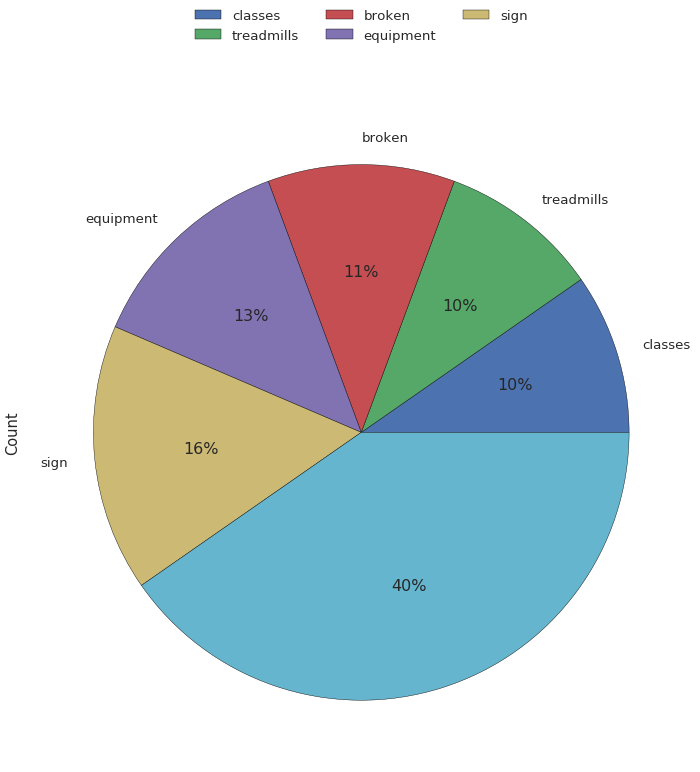

In [52]:
#Use the Pixiedust library to easily visualize the data
display(df_words.head(6))

# More Info.
For more information about PixieDust check out the following:
#### PixieDust Documentation: https://ibm-cds-labs.github.io/pixiedust/index.html
#### PixieDust GitHub Repo: https://github.com/ibm-cds-labs/pixiedust